# Introduction 

70% of the oxygen in the words atmosphere is made from marine plants, which can split into two categories larger plants (such as kelp), and plankton (photoplankton and algel plankton). Plankton also forms the foundation of aquatic food webs, including those of large, commercially important fisheries.
Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. In this notebook we will compare the performance of a convolutional neural network (CNN) in which features will be learned from images alone, with a model based on manually engineered features, which have been pre-computed by experts on the topic of oceanic microbiology. The data was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS. Plankton images were acquired in the bay of Villefranche, weekly since 2013.

Throughout the task we will learn and explore common problems in computer vision. We will preprocess the images, build a CNN, evaluate the computational cost when making CNNs, and see how they respond to an augmented dataset.

In [11]:
#all imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import zipfile
from PIL import Image, ImageOps 
from io import BytesIO 

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import csv

In [12]:
#Load the images to memory with the help of 'extract_zip_to_memory'
def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}

In [ ]:
# load the csv files 
meta = pd.read_csv('/mnt/datasets/plankton/flowcam/meta.csv')
taxo = pd.read_csv('/mnt/datasets/plankton/flowcam/taxo.csv')
features_native = pd.read_csv('/mnt/datasets/plankton/flowcam/features_native.csv.gz')
features_skimage = pd.read_csv('/mnt/datasets/plankton/flowcam/features_skimage.csv.gz')

# Data exploration 

### Data visualisation

Since 'meta.csv' contains all the necessary information about the image we will explore it's columns

In [ ]:
meta.head(1)

In [ ]:
#Load the first images
img_files = extract_zip_to_memory('/mnt/datasets/plankton/flowcam/imgs.zip')
Image.open(img_files['imgs/32756761.jpg'])

### Target value distribution

We should focus on the labels and know more about the distribution of data corresponding to the target value. The barplot below shows the distribution of the different labels that the images are assigned to. The X-axis is (log10) exponential for equal representation of unbalanced labels. 
- <b>39</b> different levels in total 
- <b>Detritus</b> - the most frequent level used in 138,439 images 
- <b>Bacteriastrum</b> - the least represented label with 12 images 

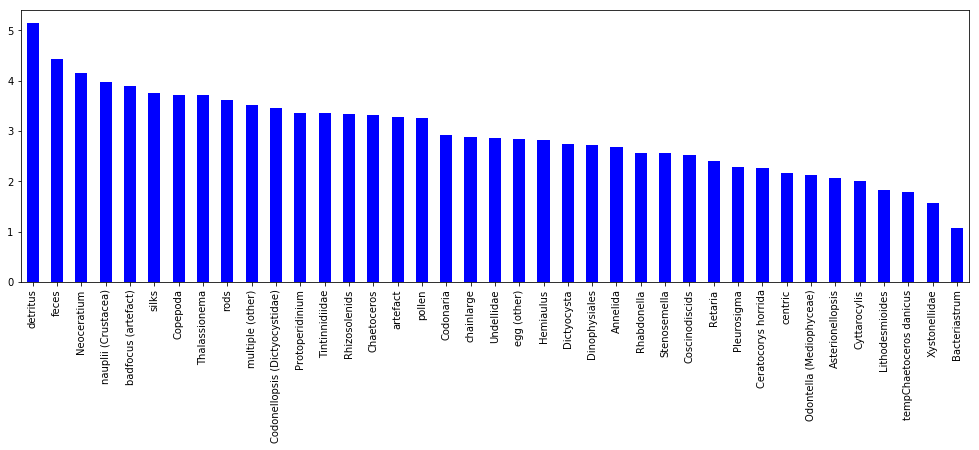

In [6]:
#Label distribution 
unique_names = np.log10(meta.level2.value_counts())
unique_names.plot(kind='bar', color= 'b', figsize=(17,5))
plt.show()

# Data pre-processing  

### Missing values  

In [8]:
#Check the dataset for NaN values 
null = meta['level2'].isnull().sum()
print('level2:', null)

level2: 1003



The fact that NaN values exist in the target column means that for some images we do not have a label. As a result, we would like to drow the rows containing these NaN values and declare the associated images unused. At level 2, we have 1,003 NaN values out of 243,610, which is 0.4% of the metadata set. We can safely remove these values, as this will not have a big negative impact.

In [9]:
#Drop rows with null value 
clean_meta = meta.dropna(subset=['level2']) 

From this moment we will continue to work with features that are assigned to one of 39 levels of 'label 2'.

### Resize image

In [10]:
filePaths = []
for key in img_files:
    filePaths.append(key)
width = [] # list of width-size of all images
height = [] # list of height-size of all images
img_size = set() # list of pairs (width, height) of all images

for i in filePaths:
    im = Image.open(img_files[i])
    img_size.add(im.size)
    width_i, height_i = im.size
    width.append(width_i)
    height.append(height_i)

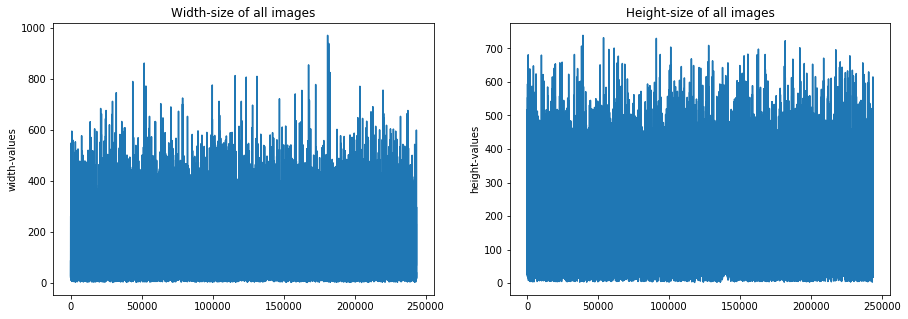

In [11]:
fig = plt.figure(figsize=(15,5))

# Draw width-values
plt.subplot(1,2,1)
plt.plot(width)
plt.title('Width-size of all images')
plt.ylabel('width-values')

#Normal probability plot
plt.subplot(1,2,2)
plt.plot(height)
plt.title('Height-size of all images')
plt.ylabel('height-values')
plt.show()

In [12]:
print('Min-max wigrh', min(width), max(width))
print('Min-max height', min(height), max(height))
print('Mediab', np.median(width), np.median(height))

Min-max wigrh 2 972
Min-max height 2 739
Mediab 67.0 87.0


This Plankton dataset is gray-scale images with their size are various - up to 53,074 different sizes - ranging from 2 to 972 pixels wide and from 2 to 739 pixels height and in each pixel. We need to scale images into the same size to a shape(64,64) so that they can be processed by the CNN models. In addition, the gray-scale value in each pixel is converted from [0,255] into [0,1], in order to satisfy the requirement of the CNN model we used.


We build our images data frame,and resize the images in the same time.

In [13]:
resize_image = pd.DataFrame([float(str(i[0].split('/')[1].split('.')[0])+'.0'),np.array(Image.open(img_files[i[0]]).resize((64,64), Image.ANTIALIAS))] for i in img_files.items())
resize_image.columns=["objid","image"]

In [14]:
#look into resized dataframe
resize_image[:3]

,objid,image
0,32689192.0,"[[255, 255, 255, 255, 255, 253, 255, 255, 255,..."
1,32721196.0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,32646531.0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


We associate numerical values to the labels, We will need this later for the model.

In [21]:
# Encode labels with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(list(meta['level2']))
labels = le.transform(list(meta['level2']))
label_names = list(le.classes_)
meta['class'] = list(labels)
meta = meta.loc[:, ['objid','class']]
export_csv = meta.to_csv (r'export_dataframe.csv', index = None, header=True)

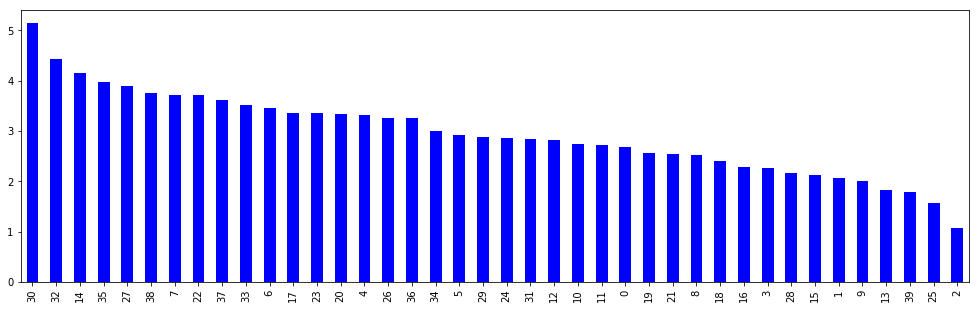

In [24]:
#Label distribution 
unique_names = np.log10(meta['class'].value_counts())
unique_names.plot(kind='bar', color= 'b', figsize=(17,5))
plt.show()